# Tanzanian Ministry of Water Dataset Modeling

**Import libraries**

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

**Import datasets**

In [7]:
y = pd.read_csv('../assets/data/dependent_vars.csv')
X = pd.read_csv('../assets/data/independent_vars.csv')
X_test = pd.read_csv('../assets/data/independent_test.csv')
SF = pd.read_csv('../assets/data/SubmissionFormat.csv')

**Creating a baseline model**

In [8]:
y['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**Create training, validation, and final test datasets**

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42)

**TMW analysis pipeline**

In [10]:
def data_preprocesser(X, y):
    # Transforming Target
    y.drop('id', axis=1, inplace=True)
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(le.classes_)
    y = pd.DataFrame(y, columns=['status_group'])

    # Transfroming Features
    # also dropping permit and public metting due to feature importance
    drop_features = ['extraction_type', 'extraction_type_group', 'waterpoint_type_group', 
                     'source', 'source_type', 'quantity_group', 'water_quality', 'payment_type', 
                     'management', 'region', 'district_code', 'num_private', 'wpt_name', 'ward', 
                     'recorded_by', 'funder', 'installer', 'subvillage', 'scheme_management',
                     'permit', 'public_meeting', 'scheme_name']
    X.drop(drop_features, axis=1, inplace=True)

    # revealing the nan values
    X.replace(0, np.nan, inplace=True)
    X.replace(-2.000000e-08, np.nan, inplace=True)
    X.replace('unknown', np.nan, inplace=True)

    # Impoting numeric features
    numeric_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 
                    'region_code', 'population', 'construction_year']

    imputer = KNNImputer(n_neighbors=5)
    X[numeric_features] = imputer.fit_transform(X[numeric_features])


    # Imputing Categorical variables
    categorical_features = ['basin', 'lga', 'extraction_type_class', 'management_group', 
                            'payment', 'quality_group', 'quantity', 'source_class', 'waterpoint_type']

    # Label encoding with a trick to keep nan values
    le = LabelEncoder()
    X[categorical_features] = X[categorical_features].apply(lambda series: pd.Series(
            le.fit_transform(series[series.notnull()]),
            index=series[series.notnull()].index
            ))


    imputer = IterativeImputer()
    X[categorical_features] = imputer.fit_transform(X[categorical_features])


    # Feature Engineering DateTime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_rec'] = X['date_recorded'].dt.month
    X['day_rec'] = X['date_recorded'].dt.day

    days_in_a_month = 31 # can potentially be done better (28, 30, 31)
    months_in_a_year = 12

    # Sin
    X['sin_day'] = np.sin((X.day_rec-1)*(2*np.pi/days_in_a_month))
    X['sin_month'] = np.sin((X.month_rec-1)*(2*np.pi/months_in_a_year))

    # Cosine
    X['cos_day'] = np.cos((X.day_rec-1)*(2*np.pi/days_in_a_month))
    X['cos_month'] = np.cos((X.month_rec-1)*(2*np.pi/months_in_a_year))

    # Engineering years in service
    X['years_in_service'] = X['year_recorded'] - X['construction_year']

    # Dropping unneeded features
    X.drop(['id'], axis=1, inplace=True)
    X.drop('date_recorded', axis=1, inplace=True)
    X.drop('construction_year', axis=1, inplace=True)
    X.drop('year_recorded', axis=1, inplace=True)
    X.drop('month_rec', axis=1, inplace=True)
    X.drop('day_rec', axis=1, inplace=True)


    return X, y

**Processing data for modeling**

In [11]:
X_train, y_train = data_preprocesser(X_train, y_train)
X_val, y_val = data_preprocesser(X_val, y_val)

C:\Users\tyler\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['functional' 'functional needs repair' 'non functional']


### Hyper perameter tunening

**Decision Tree**

Tuned Decision Tree Parameters: {'splitter': 'best', 'min_samples_leaf': 3, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 21, 'criterion': 'entropy'}
Best score is 0.7624469693152618

In [ ]:
# Parameter Distrubutions
param_dist = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [*range(2, 100, 5), None],
              'min_samples_leaf': [*range(2, 10), None],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'max_leaf_nodes': [*range(2, 10, 1), None]
              }
    

model = DecisionTreeClassifier()

model_cv = RandomizedSearchCV(model, param_dist, cv=100)

# Fit it to the data
model_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

**Random Forest**

Tuned Random Forest Parameters: {'warm_start': False, 'n_jobs': 2, 'n_estimators': 31, 'max_samples': None, 'max_features': 'sqrt', 'criterion': 'entropy'}
Best score is 0.8004041613493289

In [ ]:
param_dist = {'n_estimators': [*range(1, 100, 5), None],
              'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_jobs': [*range(0, 5, 1), None],
              'warm_start': [True, False],
              'max_samples': [2, 4, 6, 8, 10, None]
              }

model = RandomForestClassifier()

model_cv = RandomizedSearchCV(model, param_dist, cv=20)

# Fit it to the data
model_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

**Logistic Regression**

Tuned Logistic Regression Parameters: {'penalty': 'l2'}
Best score is 0.594702581369248

In [ ]:
model = LogisticRegression()

model_cv = RandomizedSearchCV(model, param_dist, cv=10)

# Fit it to the data
model_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

**ada_boost**

Tuned Logistic Regression Parameters: {'n_estimators': 11, 'learning_rate': 1.5, 'algorithm': 'SAMME.R'}
Best score is 0.6995735129068462

In [ ]:
param_dist = {'n_estimators': [*range(1, 100, 5), None],
              'learning_rate': [0.5, 1.0, 1.5, 2.0, 2.5],
              'algorithm': ['SAMME', 'SAMME.R']
              }

model = AdaBoostClassifier()

model_cv = RandomizedSearchCV(model, param_dist, cv=10)

# Fit it to the data
model_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned adaboost Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

**Gradient Boost**

Tuned Gradient Boost Parameters: {'n_estimators': 150, 'learning_rate': 0.5}
Best score is 0.7760718294051626

In [ ]:
param_dist = {
              'learning_rate': [0.5, 1.0, 1.5],
              'n_estimators': [*range(50, 250, 50), None],

              }

model = GradientBoostingClassifier()

model_cv = RandomizedSearchCV(model, param_dist, cv=10)

# Fit it to the data
model_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Gradient Boost Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

**Final fit and analysis on random forest model**

In [ ]:
# Initiat the model
model = RandomForestClassifier(warm_start=False, n_jobs=2, n_estimators=200, max_samples=None, max_features='sqrt', criterion='entropy')

# Fit the model
model.fit(X_train,y_train)

# Accuracy score
print("model score: %.3f" % model.score(X_val, y_val))

C:\Users\tyler\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



model score: 0.804


**Feature importance**

In [ ]:
rfdtmportances = pd.DataFrame(model.feature_importances_, X_train.columns, columns=['value'])

In [ ]:
rfdtmportances = pd.DataFrame(model.feature_importances_, X_train.columns, columns=['value'])

rf_importances = pd.DataFrame(model.feature_importances_, X_train.columns, columns=['value'])

rf_importances.reset_index(inplace=True)

rf_importances = rf_importances.sort_values(by='value', ascending=True)

fig = px.bar(y=rf_importances['index'], x=rf_importances['value'], width=600, height=1000, title="Random Forest Feature Importance")
fig.update_xaxes(range=[0, 0.5])
fig.show()

**Graphing confusion matrix**

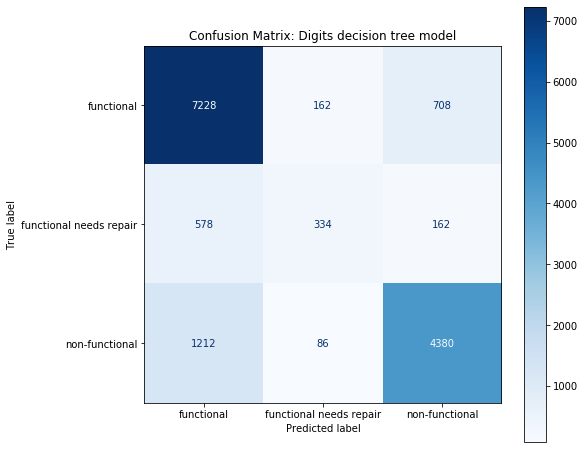

In [ ]:
# Plot the decision matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model, X_val, y_val,
                                display_labels=['functional', 'functional needs repair', 'non-functional'],
                                 cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Digits decision tree model')

plt.plot();

In [ ]:
roc_yval = y_val.copy()
roc_xval = X_val.copy()

**ROC AUC Score**

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split


#predicting the data
y_prob_pred = model.predict_proba(roc_xval)

#roc auc score
roc_auc_score(roc_yval, y_prob_pred, multi_class='ovr')

0.8905594415815173

**Ploting ROC Curve**

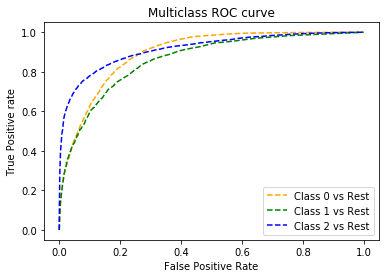

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_val, y_prob_pred[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

**Submitting to DataDriven**

In [ ]:
X_test, _ = data_preprocesser(X_test, y)

C:\Users\tyler\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['functional' 'functional needs repair' 'non functional']


In [ ]:
SF['status_group'] = model.predict(X_test)
SF.replace(0, 'functional', inplace=True)
SF.replace(1, 'functional needs repair', inplace=True)
SF.replace(2, 'non functional', inplace=True)
SF.to_csv('TMW_Predicted.csv', index=False)

**Joblibing (pickling) model for use in web-app**

In [ ]:
pkl_features = ['gps_height', 'longitude', 'latitude', 'quantity', 'years_in_service']
pkl_X = X_train[pkl_features]
pkl_y = y_train
pkl_X.to_csv('pkl_X.csv')
pkl_y.to_csv('pkl_y.csv')

# Initiat the model
model = RandomForestClassifier(warm_start=False, n_jobs=2, n_estimators=10, max_samples=None, max_features='sqrt', criterion='entropy')

# Fit the model
model.fit(pkl_X, pkl_y)

from joblib import dump, load
dump(model, 'TMWRandomForest.joblib', compress=True) 